In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device", device)
transform = transforms.Compose([
    transforms.ToTensor(),
])
trainDataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
testDataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)
trainLoader = DataLoader(trainDataset, batch_size=128, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=128, shuffle=False)

device cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.3MB/s]


In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)  # 28x28 -> 14x14
        self.enc_conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # 14x14 -> 7x7
        self.enc_fc = nn.Linear(64*7*7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 256)
        self.dec_fc2 = nn.Linear(256, 64*7*7)
        self.dec_deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1) # 7x7 -> 14x14
        self.dec_deconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)  # 14x14 -> 28x28

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)
        h = F.relu(self.enc_fc(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.dec_fc(z))
        h = F.relu(self.dec_fc2(h))
        h = h.view(-1, 64, 7, 7)
        h = F.relu(self.dec_deconv1(h))
        x_recon = torch.sigmoid(self.dec_deconv2(h))
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



## Part 1

In [4]:
def vaeLoss(x, xReconstructed, mu, logvar):
    reconLoss = F.mse_loss(
        xReconstructed, x, reduction="sum"
    )
    KLLoss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )
    return reconLoss + KLLoss, reconLoss, KLLoss
epochs = 20
trainLosses = []
valLosses = []
klLosses = []
trainReconLosses = []
klValidationLosses = []
x, _ = next(iter(trainLoader))
x = x.to(device)
model = VAE()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
recon, mu, logvar = model(x)

In [5]:
#training
for epoch in range(epochs):
    model.train()
    trainLoss = 0
    totalRecons =0
    totalKL = 0
    for x, _ in trainLoader:
        x = x.to(device)
        x_recon, mu, logvar = model(x)
        loss, recon, kl = vaeLoss(x, x_recon, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()
        totalRecons += recon.item()
        totalKL += kl.item()

    trainLoss /= len(trainDataset)
    trainLosses.append(trainLoss)
    totalRecons /= len(trainDataset)
    totalKL /= len(trainDataset)
    trainReconLosses.append(totalRecons)
    klLosses.append(totalKL)
    model.eval()
    valLoss = 0
    totalVKL = 0
    with torch.no_grad():
        for x, _ in testLoader:
            x = x.to(device)
            xReconstructed, mu, logvar = model(x)
            loss, _, vkl = vaeLoss(x, xReconstructed, mu, logvar)
            valLoss += loss.item()
            totalVKL += vkl.item()
    valLoss /= len(testDataset)
    valLosses.append(valLoss)
    totalVKL /= len(testDataset)
    klValidationLosses.append(totalVKL)
    print(f"Epoch {epoch+1}: Train {trainLoss:.4f}, Val {valLoss:.4f}")


Epoch 1: Train 36.4815, Val 28.1465
Epoch 2: Train 26.7858, Val 25.7942
Epoch 3: Train 25.4969, Val 25.0361
Epoch 4: Train 24.8497, Val 24.6832
Epoch 5: Train 24.4602, Val 24.3110
Epoch 6: Train 24.1838, Val 24.2454
Epoch 7: Train 23.9774, Val 24.1677
Epoch 8: Train 23.8153, Val 23.7859
Epoch 9: Train 23.6824, Val 23.7287
Epoch 10: Train 23.5870, Val 23.6546
Epoch 11: Train 23.4801, Val 23.5912
Epoch 12: Train 23.4173, Val 23.4651
Epoch 13: Train 23.3731, Val 23.4432
Epoch 14: Train 23.2655, Val 23.3132
Epoch 15: Train 23.2242, Val 23.2856
Epoch 16: Train 23.1815, Val 23.3027
Epoch 17: Train 23.1340, Val 23.3098
Epoch 18: Train 23.0907, Val 23.1687
Epoch 19: Train 23.0407, Val 23.1945
Epoch 20: Train 23.0029, Val 23.1659


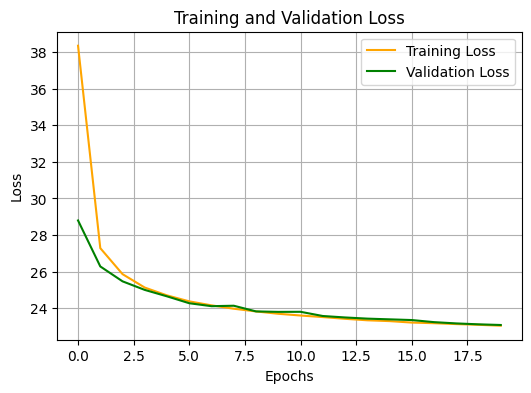

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(range(epochs), trainLosses, 'orange', label='Training Loss')
plt.plot(range(epochs), valLosses, 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png', dpi=300)

## Part2 (b) visualization

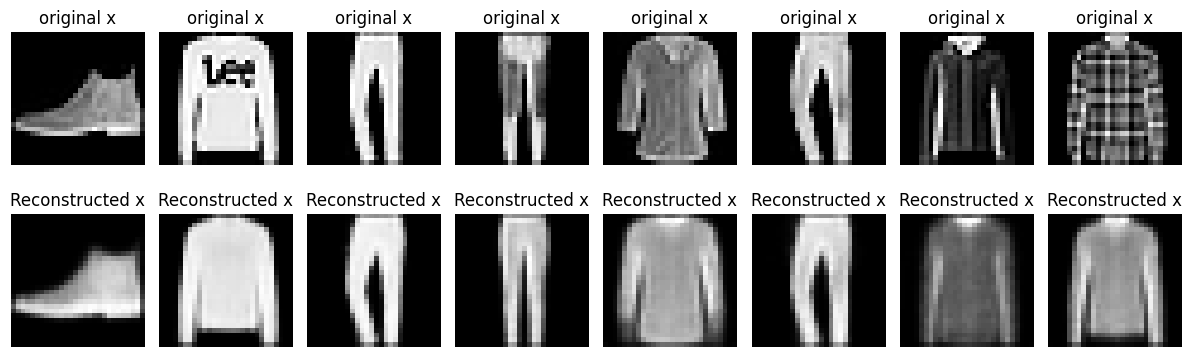

In [15]:
model.eval()
x, _ = next(iter(testLoader))
x = x.to(device)
with torch.no_grad():
    xReconstructed, _, _ = model(x)
n = 8
plt.figure(figsize=(12,4))
for i in range(n):
    # x original one
    plt.subplot(2, n, i+1)
    plt.imshow(x[i].cpu().squeeze(), cmap="gray")
    plt.title("original x")
    plt.axis("off")

    # x^telda
    plt.subplot(2, n, i+1+n)
    plt.imshow(xReconstructed[i].cpu().squeeze(), cmap="gray")
    plt.title("Reconstructed x")
    plt.axis("off")

plt.tight_layout()
plt.show()


Reconstructions preserved the overall structure and class characteristics of the input images. But finer details are blurred which is expected due to the random latent representation and we used mse error reconstruction loss

## Part 2 (c)

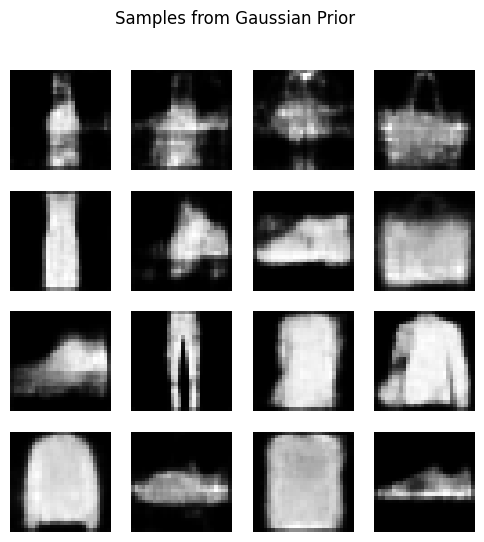

In [13]:
latentDim = 20
z = torch.randn(16, latentDim).to(device)
with torch.no_grad():
    samples = model.decode(z)
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

plt.suptitle("sampling from gaussian Prior")
plt.show()

Images resemble clothing-like shapes
Some samples ambiguous or unrealistic
Shows model learned distribution, not memorization

amples generated from the standard normal prior resemble plausible FashionMNIST items, capturing the general structure of the dataset. However, some samples lack sharpness or clear class identity, reflecting the generative uncertainty of the model.

## Part 2 (d)

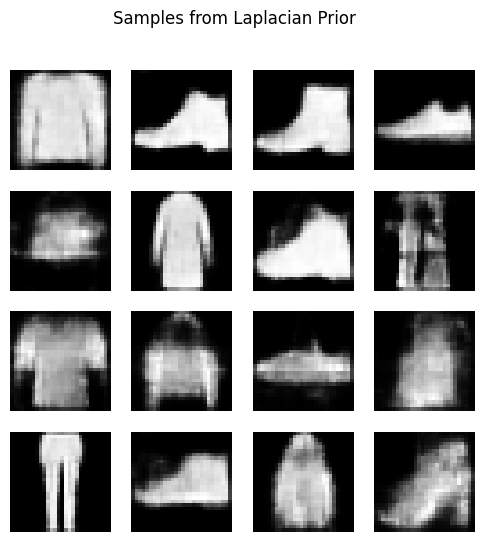

In [14]:
laplaceDistribution = torch.distributions.Laplace(
    loc=0.0, scale=1.0
)

zLaplace = laplaceDistribution.sample((16, latentDim)).to(device)
with torch.no_grad():
    laplaceSamples = model.decode(zLaplace)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(laplaceSamples[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("Sampling from Laplacian Prior")
plt.show()


When sampling from a Laplacian prior, the generated images exhibit increased artifacts and reduced structural coherence. This behavior is expected since the VAE was trained assuming a Gaussian latent prior, and sampling from a mismatched distribution leads to latent values outside the learned manifold.

## Part 3

Objective function VAE Lose e.g. ELBO consists of a reconstruction term and a KL divergence term. In my implementation the reconstruction term is the negative log likelihood of the decoder output, which is implemented as mean squared error under a Gaussian likelihood assumption and minimizing MSE plus KL divergence is equivalent to minimizing the negative ELBO.

## Part 3 c

Posterior collapse is confirmed by analyzing the KL divergence and encoder outputs. During training the KL term rapidly decreased toward zero while the reconstruction loss continued to improve. Inspection of the encoder outputs showed that the latent means were close to zero and exhibited minimal variation across different inputs, while the variances were close to one. This indicates that the learned posterior closely matches the prior and is largely independent of the input.

KL divergence is not decreasing toward zero but instead increasing initially and then stabilizes at a non-zero value.
Posterior collapse was investigated by analyzing the KL divergence and the encoder outputs. The KL term does not collapse toward zero during training; instead, it increases in early epochs and stabilizes at a non-zero value for both training and validation sets. Additionally, the latent means exhibit non-zero variance across inputs, indicating that the encoder produces input-dependent representations. Therefore, the posterior
is not collapsing to the prior, and the latent variables are being meaningfully utilized.

In [6]:
model.eval()
x, _ = next(iter(testLoader))
x = x.to(device)

with torch.no_grad():
    _, mu, logvar = model(x)

print("mu mean:", mu.mean().item())
print("mu std:", mu.std().item())
print("logvar mean:", logvar.mean().item())
print("logvar std:", logvar.std().item())

mu mean: -0.010132722556591034
mu std: 0.5078891515731812
logvar mean: -0.8076384663581848
logvar std: 1.4311978816986084


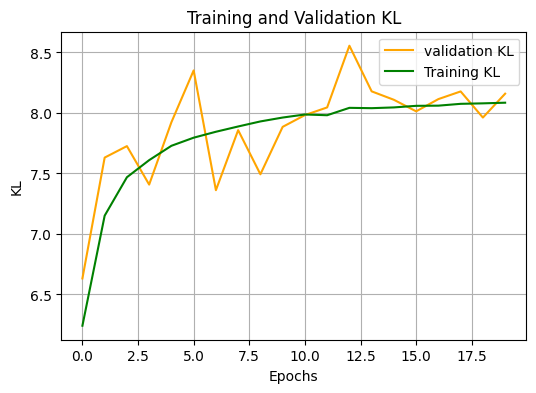

In [9]:


plt.figure(figsize=(6, 4))
plt.plot(range(epochs), klValidationLosses, 'orange', label='validation KL')
plt.plot(range(epochs), klLosses, 'green', label='Training KL')
plt.title('Training and Validation KL')
plt.xlabel('Epochs')
plt.ylabel('KL')
plt.legend()
plt.grid(True)
plt.savefig('KL_plot.png', dpi=300)

## d)
If the decoder is too powerful, it may ignore the latent variable.
Posterior collapse typically occurs when the decoder is significantly more expressive than the encoder, allowing it to model the data distribution without relying on the latent variables. In such cases, the encoder is encouraged to match the prior, causing the posterior to become independent of the input. Additionally, a strong KL regularization term early in training can force the posterior toward the prior before the encoder has learned meaningful representations, leading to collapse. This effect is especially pronounced when the KL term dominates the reconstruction loss during early optimization.

In [10]:
mu_all = []

with torch.no_grad():
    for x, _ in testLoader:
        x = x.to(device)
        _, mu, _ = model(x)
        mu_all.append(mu.cpu())

mu_all = torch.cat(mu_all, dim=0)
print("Latent variance:", mu_all.var(dim=0).mean().item())


Latent variance: 0.2574271559715271


## Part 4

In [12]:
def klBeta(epoch, warmup_epochs=10, maxBeta=1.0):
    if epoch >= warmup_epochs:
        return maxBeta
    return maxBeta * (epoch / warmup_epochs)

In [16]:
warmup_epochs = 10

for epoch in range(epochs):
    beta = klBeta(epoch, warmup_epochs=warmup_epochs, maxBeta=1.0)

    model.train()
    for x, _ in trainLoader:
        x = x.to(device)
        x_recon, mu, logvar = model(x)

        recon_loss = F.mse_loss(x_recon, x, reduction="sum")
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        loss = recon_loss + beta * kl_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [14]:
trainingLosses = []
trainingReconLosses = []
trainingKLLosses = []
for epoch in range(epochs):
    model.train()
    beta = klBeta(epoch, warmup_epochs=10, maxBeta=1.0)

    trainLoss = 0
    totalRecons = 0
    totalKL = 0

    for x, _ in trainLoader:
        x = x.to(device)
        x_recon, mu, logvar = model(x)
        loss, recon, kl = vaeLoss(x, x_recon, mu, logvar)

        loss = recon + beta * kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()
        totalRecons += recon.item()
        totalKL += kl.item()

    trainLoss /= len(trainDataset)
    totalRecons /= len(trainDataset)
    totalKL /= len(trainDataset)
    trainingLosses.append(trainLoss)
    trainingReconLosses.append(totalRecons)
    trainingKLLosses.append(totalKL)


#### Reconstructions

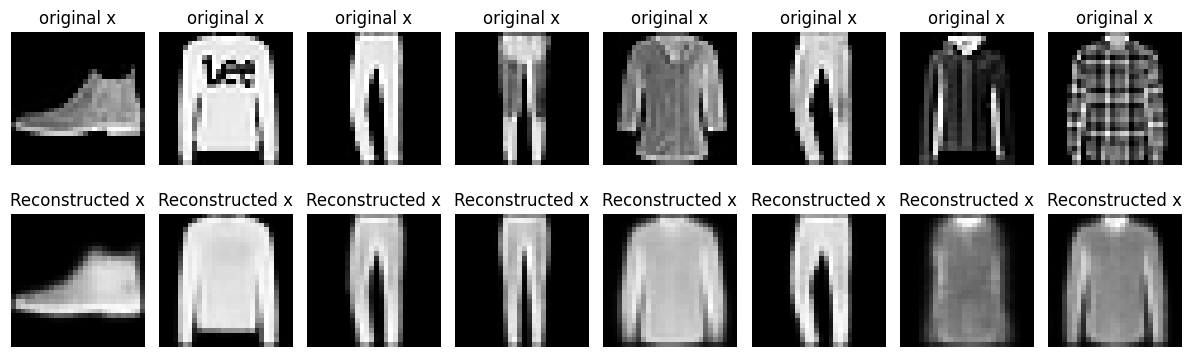

In [15]:
model.eval()
x, _ = next(iter(testLoader))
x = x.to(device)
with torch.no_grad():
    xReconstructed, _, _ = model(x)
n = 8
plt.figure(figsize=(12,4))
for i in range(n):
    # x original one
    plt.subplot(2, n, i+1)
    plt.imshow(x[i].cpu().squeeze(), cmap="gray")
    plt.title("original x")
    plt.axis("off")

    # x^telda
    plt.subplot(2, n, i+1+n)
    plt.imshow(xReconstructed[i].cpu().squeeze(), cmap="gray")
    plt.title("Reconstructed x")
    plt.axis("off")

plt.tight_layout()
plt.show()


#### Generations

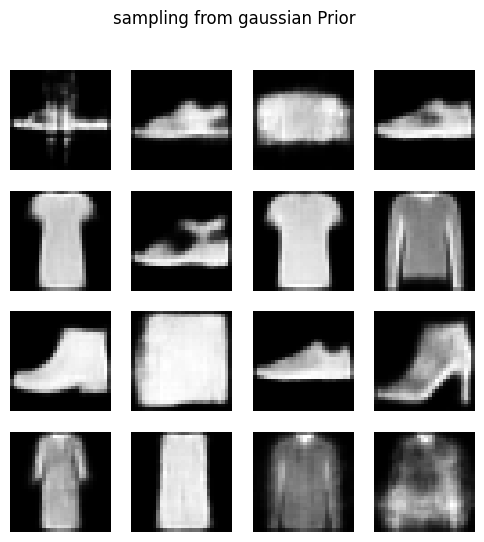

In [16]:
latentDim = 20
z = torch.randn(16, latentDim).to(device)
with torch.no_grad():
    samples = model.decode(z)
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

plt.suptitle("sampling from gaussian Prior")
plt.show()

#### KL behavior

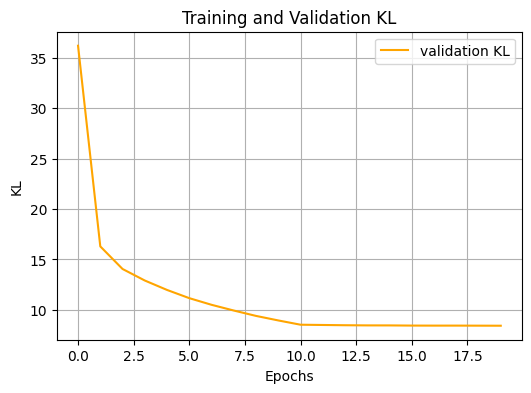

In [17]:


plt.figure(figsize=(6, 4))
plt.plot(range(epochs), trainingKLLosses, 'orange', label='validation KL')
#plt.plot(range(epochs), klLosses, 'green', label='Training KL')
plt.title('Training KL')
plt.xlabel('Epochs')
plt.ylabel('KL')
plt.legend()
plt.grid(True)
plt.savefig('KL_plot.png', dpi=300)